In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.modeling.models import Schechter1D
import astropy.constants as c2
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
data = Table.read("NSF1_match_ELG.fits")
#data= Table.read("combined.fits")

In [3]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # Create a universe model

In [4]:
def lum_mag(lum):
    result =  -2.5*np.log10(lum/3.846e33)
    return result

In [5]:
def volume_redshift(z, area):
    "Obstains the volume given a minimum and maximum redshift, using the cosmology comoving distance"
#     D_min = cosmo.luminosity_distance(z_min)
#     D_max = cosmo.luminosity_distance(z_max)

    err = 0.01
#     D_min = cosmo.comoving_distance(z-err)
#     D_max = cosmo.comoving_distance(z + err)
#     D_mid = cosmo.comoving_distance(z)

    #M = mag - 5 * np.log10(D_mid/(10 * (u.pc)))

    #m_lim = 24.98
    #d = 10*(u.pc) * 10**((m_lim-M)/5)

    #if (d > D_min) & (d < D_max):
       # volume = 4/3 * np.pi * (d ** 3 - D_min**3) * (area/(180*360))

    #else:
    #volume = 4/3 * np.pi * (D_max ** 3 - D_min**3) * (area/(180*360))
    
    radianes = (area * (np.pi / 180)**2)
    volume = (cosmo.comoving_volume(z+err) - cosmo.comoving_volume(z-err))*(radianes/4*np.pi)
    
    return volume.value 

In [6]:
def flux_lum(z, area, flux):
    
    # Convert from F_nu to F_lambda
    f_lam = []
    for f, f_nu in enumerate(flux):
        wavelength = 9640*u.AA #AA
        c_s = ac.c.to(u.AA/u.s)
        f_n = (f_nu*u.Jy*1e-6).to(u.erg/u.s/u.cm**2/u.Hz)
        f_lambda = ((c_s / wavelength**2) * f_n)
        f_lam.append(f_lambda.value)
        #print(f_lambda) #erg / (Angstrom cm2 Hz s2)
    
    f_lam = np.array(f_lam)
    f_lam = f_lam*u.erg/u.AA/u.cm**2/u.s
    phi = []
    lum = []
    lum_log = []
    for j, flux_ in enumerate(f_lam):

        D = cosmo.luminosity_distance(z)
        d_cm = D.to(u.cm)
        L = flux_*(4*np.pi*(d_cm**2))
        lum.append(L.value)
        print(L)
        lum_log.append(np.log10(L.value))
    
    
    bin_size = 0.5
    lum_log = np.array(lum_log)
    numbers = np.arange(np.min(lum_log), np.max(lum_log), bin_size)
    print('Bines: '+ str(len(numbers)))
    for i, n in enumerate(numbers):
        # print(n)
        mask = (lum_log >= n) & (lum_log < n+ bin_size)
        bin_log = lum_log[mask]
        print('Bin '+str(i)+': '+str(len(bin_log)))
        #vol_tot = []
        vol = volume_redshift(z, area)
#         for i, magn in enumerate(bin_mag):
#             vol = volume_redshift(z, area, magn)
#             vol_tot.append(1/vol)

        #phi.append(sum(vol_tot))
        phi.append((1/vol)*len(bin_log))
    phi = np.array(phi)
    lum_phi = phi/bin_size
    
    return numbers, lum_phi, lum_log

In [7]:
def lum_func(z, area, mag):

    phi = []
    mag_abs = []
    for j, mag_ap in enumerate(mag):

        D_mid = cosmo.luminosity_distance(z)
        M = mag_ap - 5*np.log10(D_mid/(10 * (u.pc)))
        mag_abs.append(M)
    
    bin_size = 0.5
    mag_abs = np.array(mag_abs)
    numbers = np.arange(np.min(mag_abs), np.max(mag_abs), bin_size)
    print('Bines: '+ str(len(numbers)))
    for i, n in enumerate(numbers):
        # print(n)
        mask = (mag_abs >= n) & (mag_abs < n+ bin_size)
        bin_mag = mag_abs[mask]
        print('Bin '+str(i)+': '+str(len(bin_mag)))
        #vol_tot = []
        vol = volume_redshift(z, area)
#         for i, magn in enumerate(bin_mag):
#             vol = volume_redshift(z, area, magn)
#             vol_tot.append(1/vol)

        #phi.append(sum(vol_tot))
        phi.append((1/vol)*len(bin_mag))

    return numbers, phi, mag_abs

# AGN

In [8]:
data2 = Table.read('AGN_C75_MATCH_REDSHIFT.fits')

In [9]:
data2

NUMBER_1_1,FLUX_ISO_1_1,FLUXERR_ISO_1_1,MAG_ISO_1_1,MAGERR_ISO_1_1,FLUX_APER_1_1,FLUXERR_APER_1_1,MAGERR_APER_1_1,MAG_APER_1_1,FLUX_AUTO_1_1,FLUXERR_AUTO_1_1,MAG_AUTO_1_1,MAGERR_AUTO_1_1,BACKGROUND_1_1,ALPHAPEAK_J2000_1_1,DELTAPEAK_J2000_1_1,X_IMAGE_1_1,Y_IMAGE_1_1,ALPHA_J2000_1_1,DELTA_J2000_1_1,FLAGS_1_1,ELONGATION_1_1,ELLIPTICITY_1_1,CLASS_STAR_1_1,FLUX_RADIUS_1_1,SNR_WIN_1_1,MAG_APER_g_1_1,FLUX_APER_g_1_1,FLUXERR_APER_g_1_1,MAGERR_APER_g_1_1,MAGERR_AUTO_g_1_1,BACKGROUND_g_1_1,MAG_AUTO_g_1_1,MAG_APER_r_1_1,FLUX_APER_r_1_1,FLUXERR_APER_r_1_1,MAGERR_APER_r_1_1,MAGERR_AUTO_r_1_1,BACKGROUND_r_1_1,MAG_AUTO_r_1_1,MAG_APER_i_1_1,FLUX_APER_i_1_1,FLUXERR_APER_i_1_1,MAGERR_APER_i_1_1,MAGERR_AUTO_i_1_1,BACKGROUND_i_1_1,MAG_AUTO_i_1_1,MAG_APER_z_1_1,FLUX_APER_z_1_1,FLUXERR_APER_z_1_1,MAGERR_APER_z_1_1,MAGERR_AUTO_z_1_1,BACKGROUND_z_1_1,MAG_AUTO_z_1_1,MAG_APER_y_1_1,FLUX_APER_y_1_1,FLUXERR_APER_y_1_1,MAGERR_APER_y_1_1,MAGERR_AUTO_y_1_1,BACKGROUND_y_1_1,MAG_AUTO_y_1_1,NUMBER_2,FLUX_ISO_2,FLUXERR_ISO_2,MAG_ISO_2,MAGERR_ISO_2,FLUX_APER_2,FLUXERR_APER_2,MAGERR_APER_2,MAG_APER_2,FLUX_AUTO_2,FLUXERR_AUTO_2,MAG_AUTO_2,MAGERR_AUTO_2,BACKGROUND_2,ALPHAPEAK_J2000_2,DELTAPEAK_J2000_2,X_IMAGE_2,Y_IMAGE_2,ALPHA_J2000_2,DELTA_J2000_2,FLAGS_2,ELONGATION_2,ELLIPTICITY_2,CLASS_STAR_2,FLUX_RADIUS_2,SNR_WIN_2,MAG_APER_g_2,FLUX_APER_g_2,FLUXERR_APER_g_2,MAGERR_APER_g_2,MAGERR_AUTO_g_2,BACKGROUND_g_2,MAG_AUTO_g_2,MAG_APER_r_2,FLUX_APER_r_2,FLUXERR_APER_r_2,MAGERR_APER_r_2,MAGERR_AUTO_r_2,BACKGROUND_r_2,MAG_AUTO_r_2,MAG_APER_i_2,FLUX_APER_i_2,FLUXERR_APER_i_2,MAGERR_APER_i_2,MAGERR_AUTO_i_2,BACKGROUND_i_2,MAG_AUTO_i_2,MAG_APER_z_2,FLUX_APER_z_2,FLUXERR_APER_z_2,MAGERR_APER_z_2,MAGERR_AUTO_z_2,BACKGROUND_z_2,MAG_AUTO_z_2,MAG_APER_y_2,FLUX_APER_y_2,FLUXERR_APER_y_2,MAGERR_APER_y_2,MAGERR_AUTO_y_2,BACKGROUND_y_2,MAG_AUTO_y_2,Separation_1,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,NUMBER_1_2,FLUX_ISO_1_2,FLUXERR_ISO_1_2,MAG_ISO_1_2,MAGERR_ISO_1_2,FLUX_APER_1_2,FLUXERR_APER_1_2,MAGERR_APER_1_2,MAG_APER_1_2,FLUX_AUTO_1_2,FLUXERR_AUTO_1_2,MAG_AUTO_1_2,MAGERR_AUTO_1_2,BACKGROUND_1_2,ALPHAPEAK_J2000_1_2,DELTAPEAK_J2000_1_2,X_IMAGE_1_2,Y_IMAGE_1_2,ALPHA_J2000_1_2,DELTA_J2000_1_2,FLAGS_1_2,ELONGATION_1_2,ELLIPTICITY_1_2,CLASS_STAR_1_2,FLUX_RADIUS_1_2,SNR_WIN_1_2,MAG_APER_g_1_2,FLUX_APER_g_1_2,FLUXERR_APER_g_1_2,MAGERR_APER_g_1_2,MAGERR_AUTO_g_1_2,BACKGROUND_g_1_2,MAG_AUTO_g_1_2,MAG_APER_r_1_2,FLUX_APER_r_1_2,FLUXERR_APER_r_1_2,MAGERR_APER_r_1_2,MAGERR_AUTO_r_1_2,BACKGROUND_r_1_2,MAG_AUTO_r_1_2,MAG_APER_i_1_2,FLUX_APER_i_1_2,FLUXERR_APER_i_1_2,MAGERR_APER_i_1_2,MAGERR_AUTO_i_1_2,BACKGROUND_i_1_2,MAG_AUTO_i_1_2,MAG_APER_z_1_2,FLUX_APER_z_1_2,FLUXERR_APER_z_1_2,MAGERR_APER_z_1_2,MAGERR_AUTO_z_1_2,BACKGROUND_z_1_2,MAG_AUTO_z_1_2,MAG_APER_y_1_2,FLUX_APER_y_1_2,FLUXERR_APER_y_1_2,MAGERR_APER_y_1_2,MAGERR_AUTO_y_1_2,BACKGROUND_y_1_2,MAG_AUTO_y_1_2,IDENT,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,SCALE_BEST,NBAND_USED,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,CONTEXT,ZSPEC,MAG_OBS0,MAG_OBS1,MAG_OBS2,MAG_OBS3,MAG_OBS4,ERR_MAG_OBS0,ERR_MAG_OBS1,ERR_MAG_OBS2,ERR_MAG_OBS3,ERR_MAG_OBS4,MAG_MOD0,MAG_MOD1,MAG_MOD2,MAG_MOD3,MAG_MOD4,MAG_ABS0,MAG_ABS1,MAG_ABS2,MAG_ABS3,MAG_ABS04,MABS_FILT0,MABS_FILT1,MABS_FILT2,MABS_FILT3,MABS_FILT4,STRING_INPUT,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
int32,float32,float32,float32,float32,float32[13],float32[13],float32[13],float64[13],float32,float32,float64,float32,float32,float64,float64,float32,float32,float64,float64,int16,float32,float32,float32,float32,float32,float64[13],float32[13],float32[13],float32[13],float32,float32,float64,float64[13],float32[13],float32[13],float32[13],float32,float32,float64,float64[13],float32[13],float3

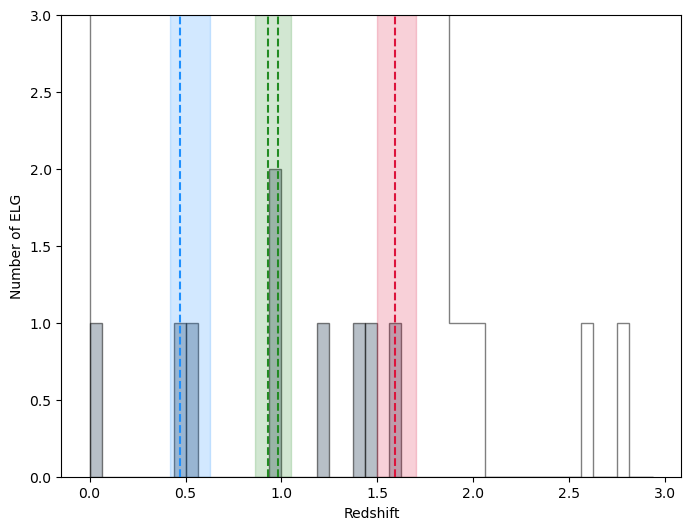

In [19]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)



ax.hist(data2['Z_BEST'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')

ax.hist(data['Z_BEST'], bins =bins, histtype ='step', alpha = 0.5, 
         color = 'slategray',ec = 'k')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.42, 0.63, alpha=0.2, color='dodgerblue')
#ax.text(0.38, 650, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
#ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
#ax.text(0.8, 650, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.5, 1.7, alpha=0.2, color='crimson')
#ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')


ax.set_ylim(0,3)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

In [20]:
mask1b = (0.42 < data2['Z_BEST']) & (data2['Z_BEST'] < 0.63)
H_a2 = data2[mask1b]

In [10]:
# fig,ax=plt.subplots(figsize=(8,6), dpi=100)

# bins = np.arange(0,3,0.0625)



# ax.hist(H_a2['FLUXERR_APER_1_1'], bins =bins, histtype ='bar', alpha = 0.5, 
#          color = 'slategray',ec = 'k')


# plt.show()

In [ ]:
data2

In [ ]:
numbers_list = data2['NUMBER_1_1']
for i in numbers_list:
    data.remove_rows(data['NUMBER_1']==i)

In [ ]:
data

In [ ]:
data.write('NSF1_Bagpipes_NO_AGN.fits', format='fits', overwrite = True)

In [12]:
pop =0.24237648

In [22]:
aper = 2
BB = np.array([data['MAG_APER_z_1'][i][aper] for i in range(len(data))])
ew_end = 0.44

NB_5s = 24.98

NB = np.array([data['MAG_APER_1'][i][aper] for i in range(len(data))])+ pop

In [14]:
BB2 = np.array([data2['MAG_APER_z_1_1'][i][aper] for i in range(len(data2))])

NB2 = np.array([data2['MAG_APER_1'][i][aper] for i in range(len(data2))])+ pop

KeyError: 'MAG_APER_z_1'

In [ ]:
fig, ax= plt.subplots(figsize =(12,8))


#ax.scatter(NB_corr, -(BB-NB_corr), s =1, color ='slategray')
ax.scatter(NB, BB-NB, s =0.1, color ='k')
ax.scatter(NB2, BB2-NB2, s =50, color ='blue', label = 'AGN')
#ax.scatter(np.array(Narrowb), np.array(Broadb)-np.array(Narrowb), s =1, color ='royalblue')
#ax.plot(mags[:-numb], sigma_c, color = 'crimson',alpha =0.8)
# ax.scatter(NB_cc,BB_cc-NB_cc,s=1)
#ax.plot(numbers,sig_clip, color = 'crimson')
#ax.scatter(NB_s, BB_s-NB_s, color = 'dodgerblue', s =0.1)
#.plot(numbers,cs_crit, color = 'cyan')
ax.set_xlim(18,27) 
ax.set_ylim(-1,5)
ax.set_ylabel(r'$(z - NB964)_{corr}$')
ax.set_xlabel(r'$NB964_{corr}$')
#ax.hlines(0,18,27, linestyle='dotted', color ='hotpink')
ax.hlines(ew_end,18,27, linestyle='dashed', color ='limegreen')
ax.vlines(NB_5s,-1,5, linestyle='dashed', color ='coral')
plt.legend()
plt.show()

# H-$\alpha$

In [ ]:
#mask1 =  (0.4 < table['Z_BEST']) & (table['Z_BEST'] < 0.55)
mask1 =  (0.44 < data['Z_BEST']) & (data['Z_BEST'] < 0.5)
H_a = data[mask1]

In [15]:
BBa = np.array([H_a['MAG_APER_z_1'][i][aper] for i in range(len(H_a))])

NBa = np.array([H_a['MAG_APER_1'][i][aper] for i in range(len(H_a))])+ pop

NameError: name 'H_a' is not defined

NameError: name 'NBa' is not defined

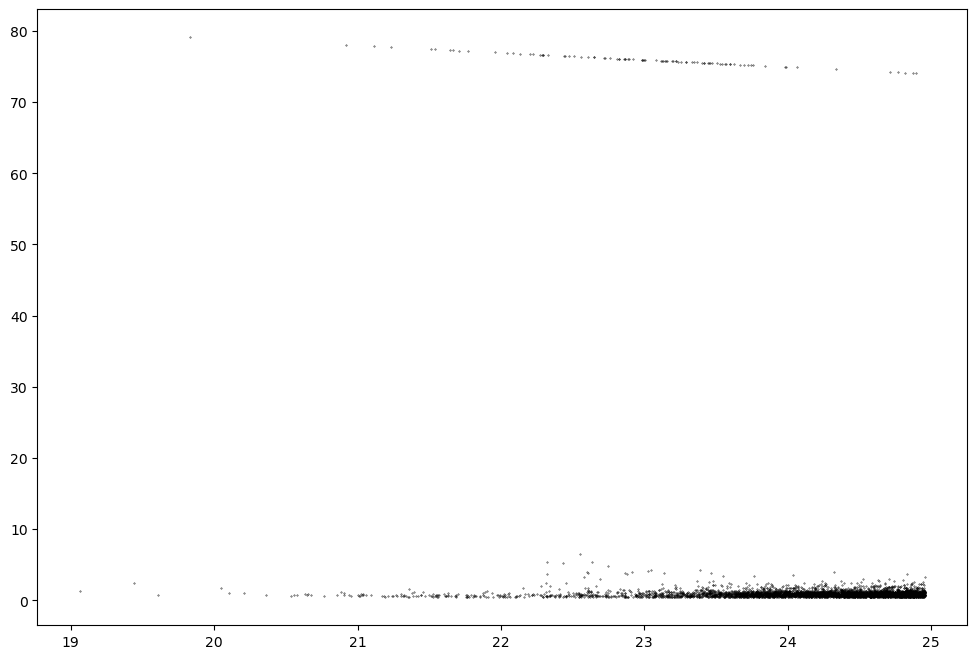

In [16]:
fig, ax= plt.subplots(figsize =(12,8))


#ax.scatter(NB_corr, -(BB-NB_corr), s =1, color ='slategray')
ax.scatter(NB, BB-NB, s =0.1, color ='k')
ax.scatter(NBa, BBa-NBa, s =5, color ='blue', label = r'$H\alpha$', marker = '*')
#ax.scatter(np.array(Narrowb), np.array(Broadb)-np.array(Narrowb), s =1, color ='royalblue')
#ax.plot(mags[:-numb], sigma_c, color = 'crimson',alpha =0.8)
# ax.scatter(NB_cc,BB_cc-NB_cc,s=1)
#ax.plot(numbers,sig_clip, color = 'crimson')
#ax.scatter(NB_s, BB_s-NB_s, color = 'dodgerblue', s =0.1)
#.plot(numbers,cs_crit, color = 'cyan')
ax.set_xlim(18,27) 
ax.set_ylim(-1,5)
ax.set_ylabel(r'$(z - NB964)_{corr}$')
ax.set_xlabel(r'$NB964_{corr}$')
#ax.hlines(0,18,27, linestyle='dotted', color ='hotpink')
ax.hlines(ew_end,18,27, linestyle='dashed', color ='limegreen')
ax.vlines(NB_5s,-1,5, linestyle='dashed', color ='coral')
plt.legend()
plt.show()

# [OIII]

In [ ]:
mask2 = (0.86 < data['Z_BEST'] ) & (data['Z_BEST'] < 1.05)
O_III = data[mask2]

In [17]:
BBb = np.array([O_III['MAG_APER_z_1'][i][aper] for i in range(len(O_III))])

NBb = np.array([O_III['MAG_APER_1'][i][aper] for i in range(len(O_III))])+ pop

NameError: name 'O_III' is not defined

NameError: name 'NBb' is not defined

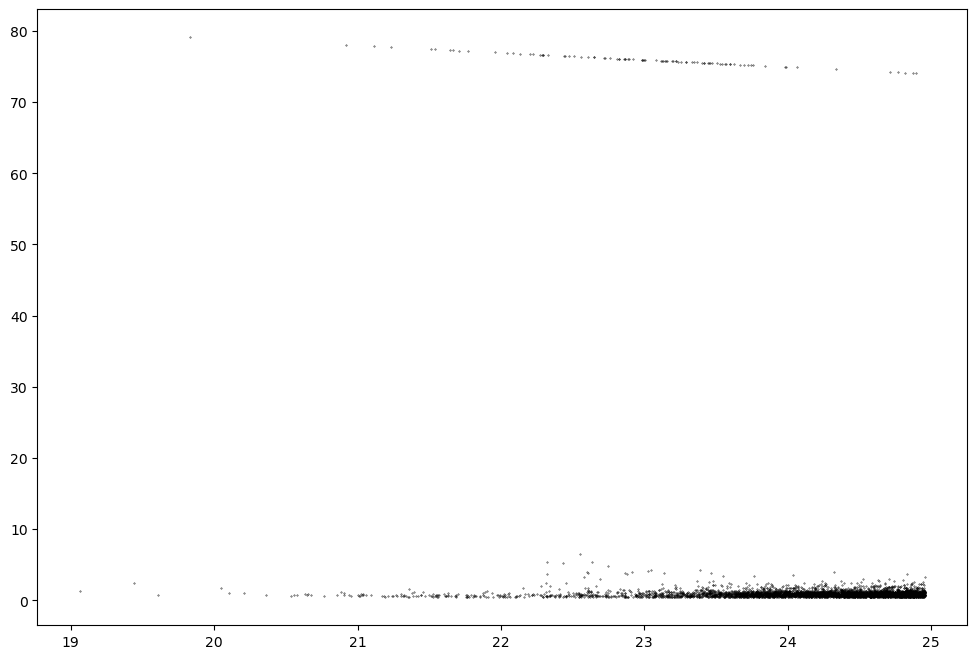

In [18]:
fig, ax= plt.subplots(figsize =(12,8))


#ax.scatter(NB_corr, -(BB-NB_corr), s =1, color ='slategray')
ax.scatter(NB, BB-NB, s =0.1, color ='k')
ax.scatter(NBb, BBb-NBb, s =5, color ='forestgreen', label = r'[OIII]', marker = '*')
#ax.scatter(np.array(Narrowb), np.array(Broadb)-np.array(Narrowb), s =1, color ='royalblue')
#ax.plot(mags[:-numb], sigma_c, color = 'crimson',alpha =0.8)
# ax.scatter(NB_cc,BB_cc-NB_cc,s=1)
#ax.plot(numbers,sig_clip, color = 'crimson')
#ax.scatter(NB_s, BB_s-NB_s, color = 'dodgerblue', s =0.1)
#.plot(numbers,cs_crit, color = 'cyan')
ax.set_xlim(18,27) 
ax.set_ylim(-1,5)
ax.set_ylabel(r'$(z - NB964)_{corr}$')
ax.set_xlabel(r'$NB964_{corr}$')
#ax.hlines(0,18,27, linestyle='dotted', color ='hotpink')
ax.hlines(ew_end,18,27, linestyle='dashed', color ='limegreen')
ax.vlines(NB_5s,-1,5, linestyle='dashed', color ='coral')
plt.legend()
plt.show()

# [OII]

In [ ]:
mask3 = (1.5 < data['Z_BEST'] ) & (data['Z_BEST'] < 1.7)
O_II = data[mask3]

In [19]:
BBc = np.array([O_II['MAG_APER_z_1'][i][aper] for i in range(len(O_II))])

NBc = np.array([O_II['MAG_APER_1'][i][aper] for i in range(len(O_II))])+ pop

NameError: name 'O_II' is not defined

NameError: name 'NBc' is not defined

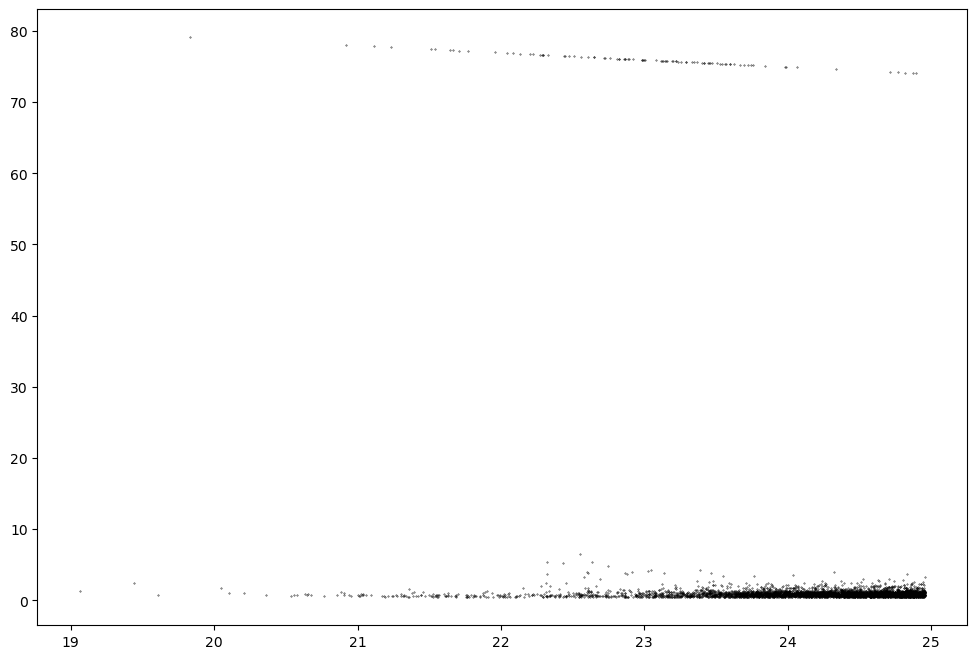

In [20]:
fig, ax= plt.subplots(figsize =(12,8))


#ax.scatter(NB_corr, -(BB-NB_corr), s =1, color ='slategray')
ax.scatter(NB, BB-NB, s =0.1, color ='k')
ax.scatter(NBc, BBc-NBc, s =5, color ='red', label = r'[OII]', marker = '*')
#ax.scatter(np.array(Narrowb), np.array(Broadb)-np.array(Narrowb), s =1, color ='royalblue')
#ax.plot(mags[:-numb], sigma_c, color = 'crimson',alpha =0.8)
# ax.scatter(NB_cc,BB_cc-NB_cc,s=1)
#ax.plot(numbers,sig_clip, color = 'crimson')
#ax.scatter(NB_s, BB_s-NB_s, color = 'dodgerblue', s =0.1)
#.plot(numbers,cs_crit, color = 'cyan')
ax.set_xlim(18,27) 
ax.set_ylim(-1,5)
ax.set_ylabel(r'$(z - NB964)_{corr}$')
ax.set_xlabel(r'$NB964_{corr}$')
#ax.hlines(0,18,27, linestyle='dotted', color ='hotpink')
ax.hlines(ew_end,18,27, linestyle='dashed', color ='limegreen')
ax.vlines(NB_5s,-1,5, linestyle='dashed', color ='coral')
plt.legend()
plt.show()